In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import bilby
import ptemcee

from toy import (
    SimpleGaussianLikelihood, GeneralizedNormalLikelihood, sample_generalized_gaussian,
    alpha_to_sigma, sigma_to_alpha,
    temper_posterior_weights, plot_tempered_posterior_weights, generate_ptemcee_pos0,
    plot_posterior_predictive_distribution
)

from util import HYBRID_COLOR, COMP_COLOR, HYBRID_EVOL_COLORS

plt.style.use("./tgr-hybrid-sampling.mplstyle")

%load_ext autoreload
%autoreload 2

# Well-specified Model

In [2]:
N = 10000
mu_true = 3
alpha_true = 5
beta_true = 2

data = sample_generalized_gaussian(mu_true, alpha_true, beta_true, N)

## First Step - Dynesty

In [3]:
label = "wellspecified_dynesty-step"
outdir = "./wellspecified/wellspecified_dynesty-step" 

gaussian_likelihood = SimpleGaussianLikelihood(data)
priors = dict(
    mu=bilby.core.prior.Uniform(0, 5, 'mu'),
    sigma=bilby.core.prior.Uniform(0, 10, 'sigma'),
)

nlive = 500

# And run sampler
result_hybrid_nest = bilby.run_sampler(
    likelihood=gaussian_likelihood, priors=priors, sampler='dynesty', npoints=nlive,
    walks=10, outdir=outdir, label=label)

21:26 bilby INFO    : Running for label 'wellspecified_dynesty-step', output will be saved to './wellspecified/wellspecified_dynesty-step'
21:26 bilby INFO    : Search parameters:
21:26 bilby INFO    :   mu = Uniform(minimum=0, maximum=5, name='mu', latex_label='mu', unit=None, boundary=None)
21:26 bilby INFO    :   sigma = Uniform(minimum=0, maximum=10, name='sigma', latex_label='sigma', unit=None, boundary=None)
21:26 bilby INFO    : Single likelihood evaluation took 5.236e-05 s


0it [00:00, ?it/s]

21:26 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fc2f0023850>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
21:26 bilby INFO    : Checkpoint every check_point_delta_t = 600s
21:26 bilby INFO    : Using dynesty version 1.0.1
21:26 bilby INFO    : Using the bilby-implemented rwalk samp

5715it [00:21, 164.65it/s, bound:657 nc: 50 ncall:2.1e+05 eff:2.7% logz=-26914.36+/-0.18 dlogz:0.100>0.1]  

21:27 bilby INFO    : Written checkpoint file ./wellspecified/wellspecified_dynesty-step/wellspecified_dynesty-step_resume.pickle
21:27 bilby INFO    : Writing 1258 current samples to ./wellspecified/wellspecified_dynesty-step/wellspecified_dynesty-step_samples.dat
/Users/newolfe/opt/anaconda3/envs/tgr-hybrid-analysis/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


5715it [00:29, 194.56it/s, bound:657 nc:  1 ncall:2.1e+05 eff:2.9% logz=-26914.27+/-0.18 dlogz:0.000>0.1]



21:27 bilby INFO    : Sampling time: 0:00:21.890308
21:27 bilby INFO    : Summary of results:
nsamples: 6215
ln_noise_evidence:    nan
ln_evidence: -26914.266 +/-  0.180
ln_bayes_factor:    nan +/-  0.180



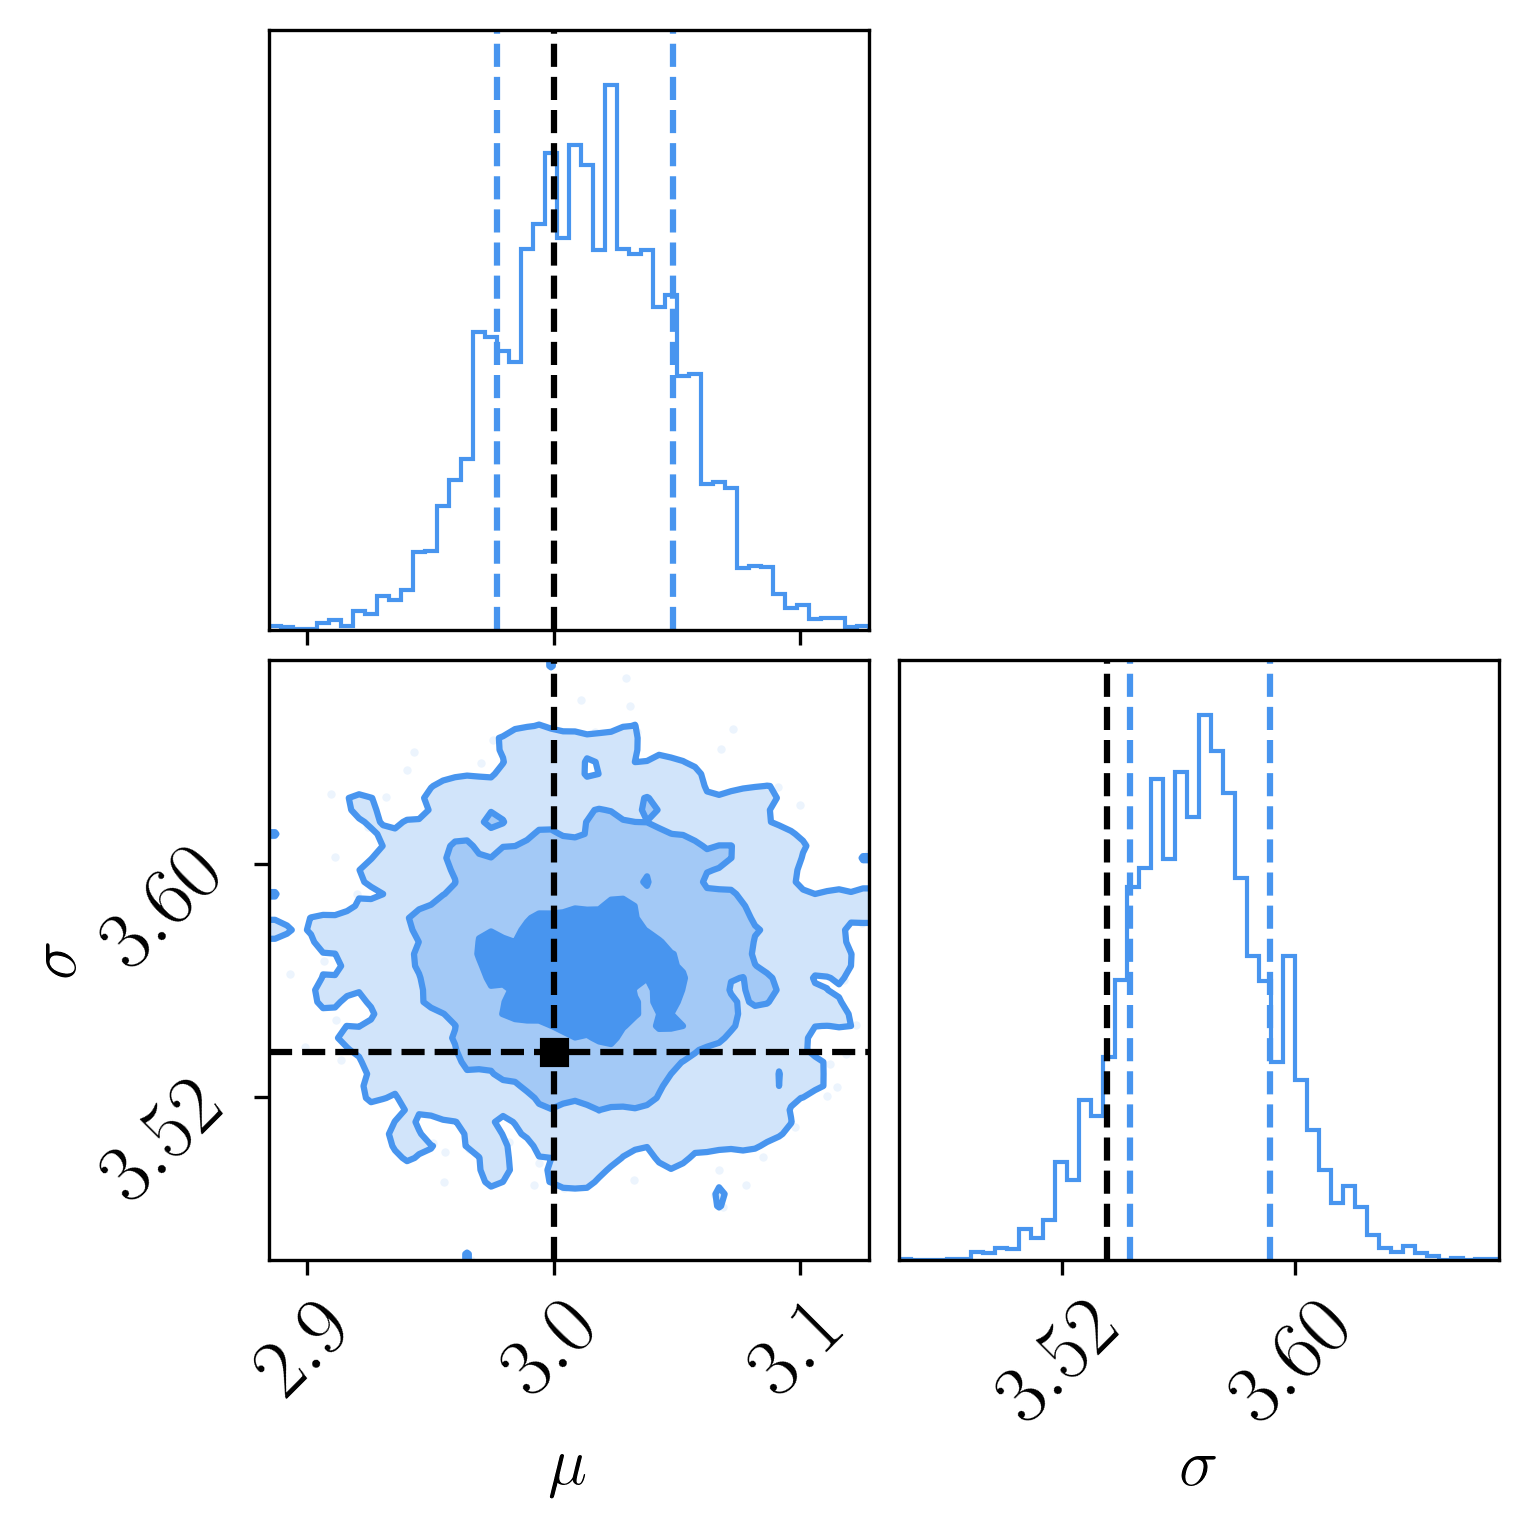

In [4]:
with plt.rc_context({'lines.linestyle' : '--'}):
    fig = result_hybrid_nest.plot_corner(
        parameters=dict(
            mu=mu_true,
            sigma=alpha_to_sigma(alpha_true)
        ),
        titles=False,
        labels=[r"$\mu$", r"$\sigma$"],
        color=COMP_COLOR,
        truth_color="black",
        dpi=80
    )

fig

## Second Step - ptemcee

### Setup Tempered Initial Points

In [5]:
label_pt = "wellspecified_ptemcee-step"
outdir_pt = "./wellspecified/wellspecified_ptemcee-step"

ndims    = 3   # 3 dimensions i.e. parameters, {mu, alpha, beta}
nwalkers = 200 # number of walkers in our ensemble
ntemps   = 7   # number of temperatures in our ensemble

# generate the temperatures in our ensemble
beta_T = ptemcee.default_beta_ladder(
    ndim=ndims,            
    ntemps=ntemps,
    Tmax=None
)

In [6]:
nested_samples = result_hybrid_nest.nested_samples

tempered_posterior_weights = temper_posterior_weights(
    nlive = nlive, 
    log_likelihood = nested_samples["log_likelihood"].values, 
    beta_T = beta_T
)

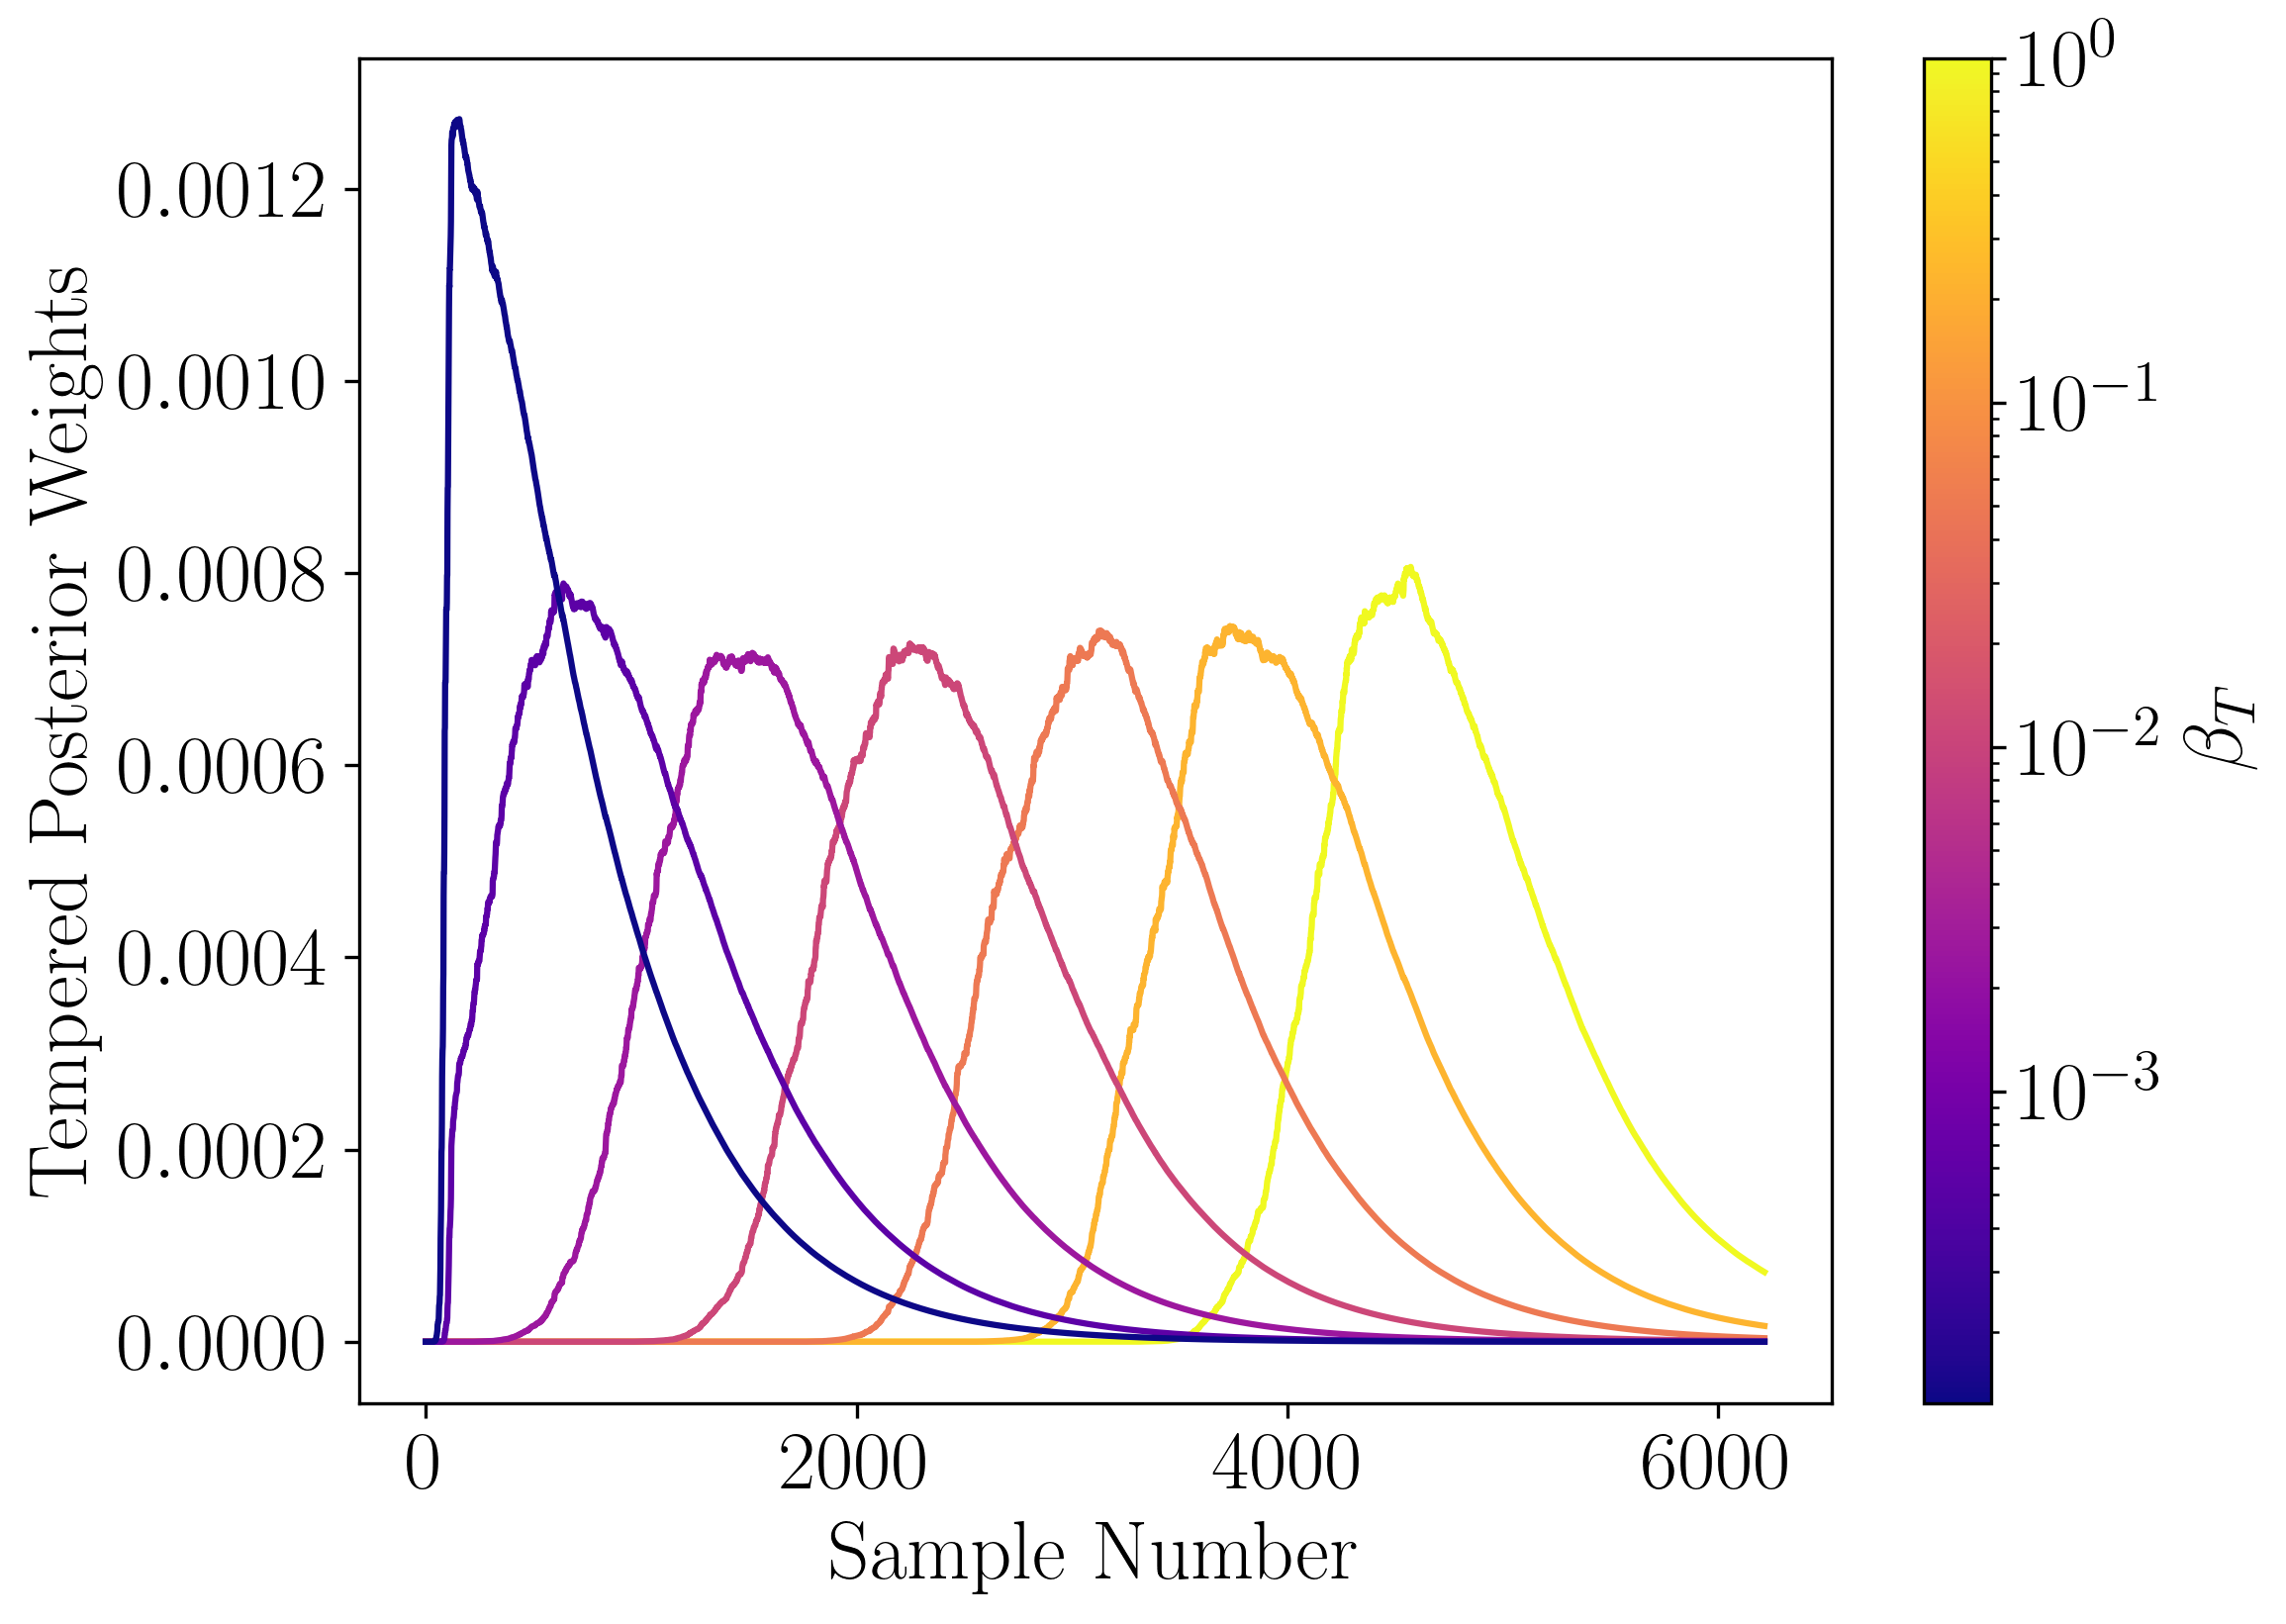

In [7]:
with plt.rc_context({'figure.figsize' : (8, 6)}):
    plot_tempered_posterior_weights(
        beta_T = beta_T,
        tempered_posterior_weights = tempered_posterior_weights
)

In [8]:
pos0 = generate_ptemcee_pos0(
    ntemps = ntemps,
    nwalkers = nwalkers,
    ndims = ndims,
    tempered_posterior_weights = tempered_posterior_weights,
    nested_samples = nested_samples
)

21:27 bilby INFO    : Running for label 'wellspecified_ptemcee-step', output will be saved to './wellspecified/wellspecified_ptemcee-step'
21:27 bilby INFO    : Search parameters:
21:27 bilby INFO    :   mu = Uniform(minimum=0, maximum=5, name=None, latex_label='$\\mu$', unit=None, boundary=None)
21:27 bilby INFO    :   alpha = Uniform(minimum=0, maximum=14.142135623730951, name=None, latex_label='$\\alpha$', unit=None, boundary=None)
21:27 bilby INFO    :   beta = Uniform(minimum=0, maximum=10, name=None, latex_label='$\\beta$', unit=None, boundary=None)
21:27 bilby INFO    : Single likelihood evaluation took 3.364e-04 s
21:27 bilby WARNING : Supplied argument 'npool' not an argument of 'Ptemcee', removing.
21:27 bilby INFO    : Using sampler Ptemcee with kwargs {'ntemps': 7, 'nwalkers': 200, 'Tmax': None, 'betas': array([1.00000000e+00, 2.23462688e-01, 4.99355731e-02, 1.11587374e-02,
       2.49356146e-03, 5.57217948e-04, 1.24517421e-04]), 'a': 2.0, 'adaptation_lag': 10000, 'adaptati

1|0:00:02|nc:7.0e+03|a0:0.00-1.00|swp:0.30-0.59|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.39ms/ev
2|0:00:03|nc:1.4e+04|a0:0.20-1.00|swp:0.27-0.60|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.25ms/ev
3|0:00:04|nc:2.1e+04|a0:0.27-0.93|swp:0.26-0.61|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.20ms/ev
4|0:00:04|nc:2.8e+04|a0:0.35-0.90|swp:0.26-0.60|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.10ms/ev
5|0:00:05|nc:3.5e+04|a0:0.40-0.88|swp:0.26-0.59|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.09ms/ev
6|0:00:06|nc:4.2e+04|a0:0.47-0.83|swp:0.25-0.60|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.09ms/ev
7|0:00:06|nc:4.9e+04|a0:0.46-0.83|swp:0.25-0.59|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.10ms/ev
8|0:00:07|nc:5.6e+04|a0:0.47-0.82|swp:0.25-0.59|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.10ms/ev
9|0:00:08|nc:6.3e+04|a0:0.47-0.82|swp:0.25-0.59|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.11ms/ev
10|0:00:09|nc:7.0e+04|a0:0.42-0.80|swp:0.25-0.59|n:nan<5000|t!nan(+nan,+nan)|q:inf|0.10ms/ev
11|0:00:09|nc:7.7e+04|a0:0.45-0.80|swp:0.25-0.59|n:nan<5000|t!nan(+nan,+nan)|q:

21:29 bilby INFO    : Finished sampling
21:29 bilby INFO    : Writing checkpoint and diagnostics
21:29 bilby INFO    : Finished writing checkpoint
21:29 bilby INFO    : Sampling time: 0:02:20.889959
21:29 bilby INFO    : Summary of results:
nsamples: 22000
ln_noise_evidence:    nan
ln_evidence: -26918.972 +/- 19.747
ln_bayes_factor:    nan +/- 19.747



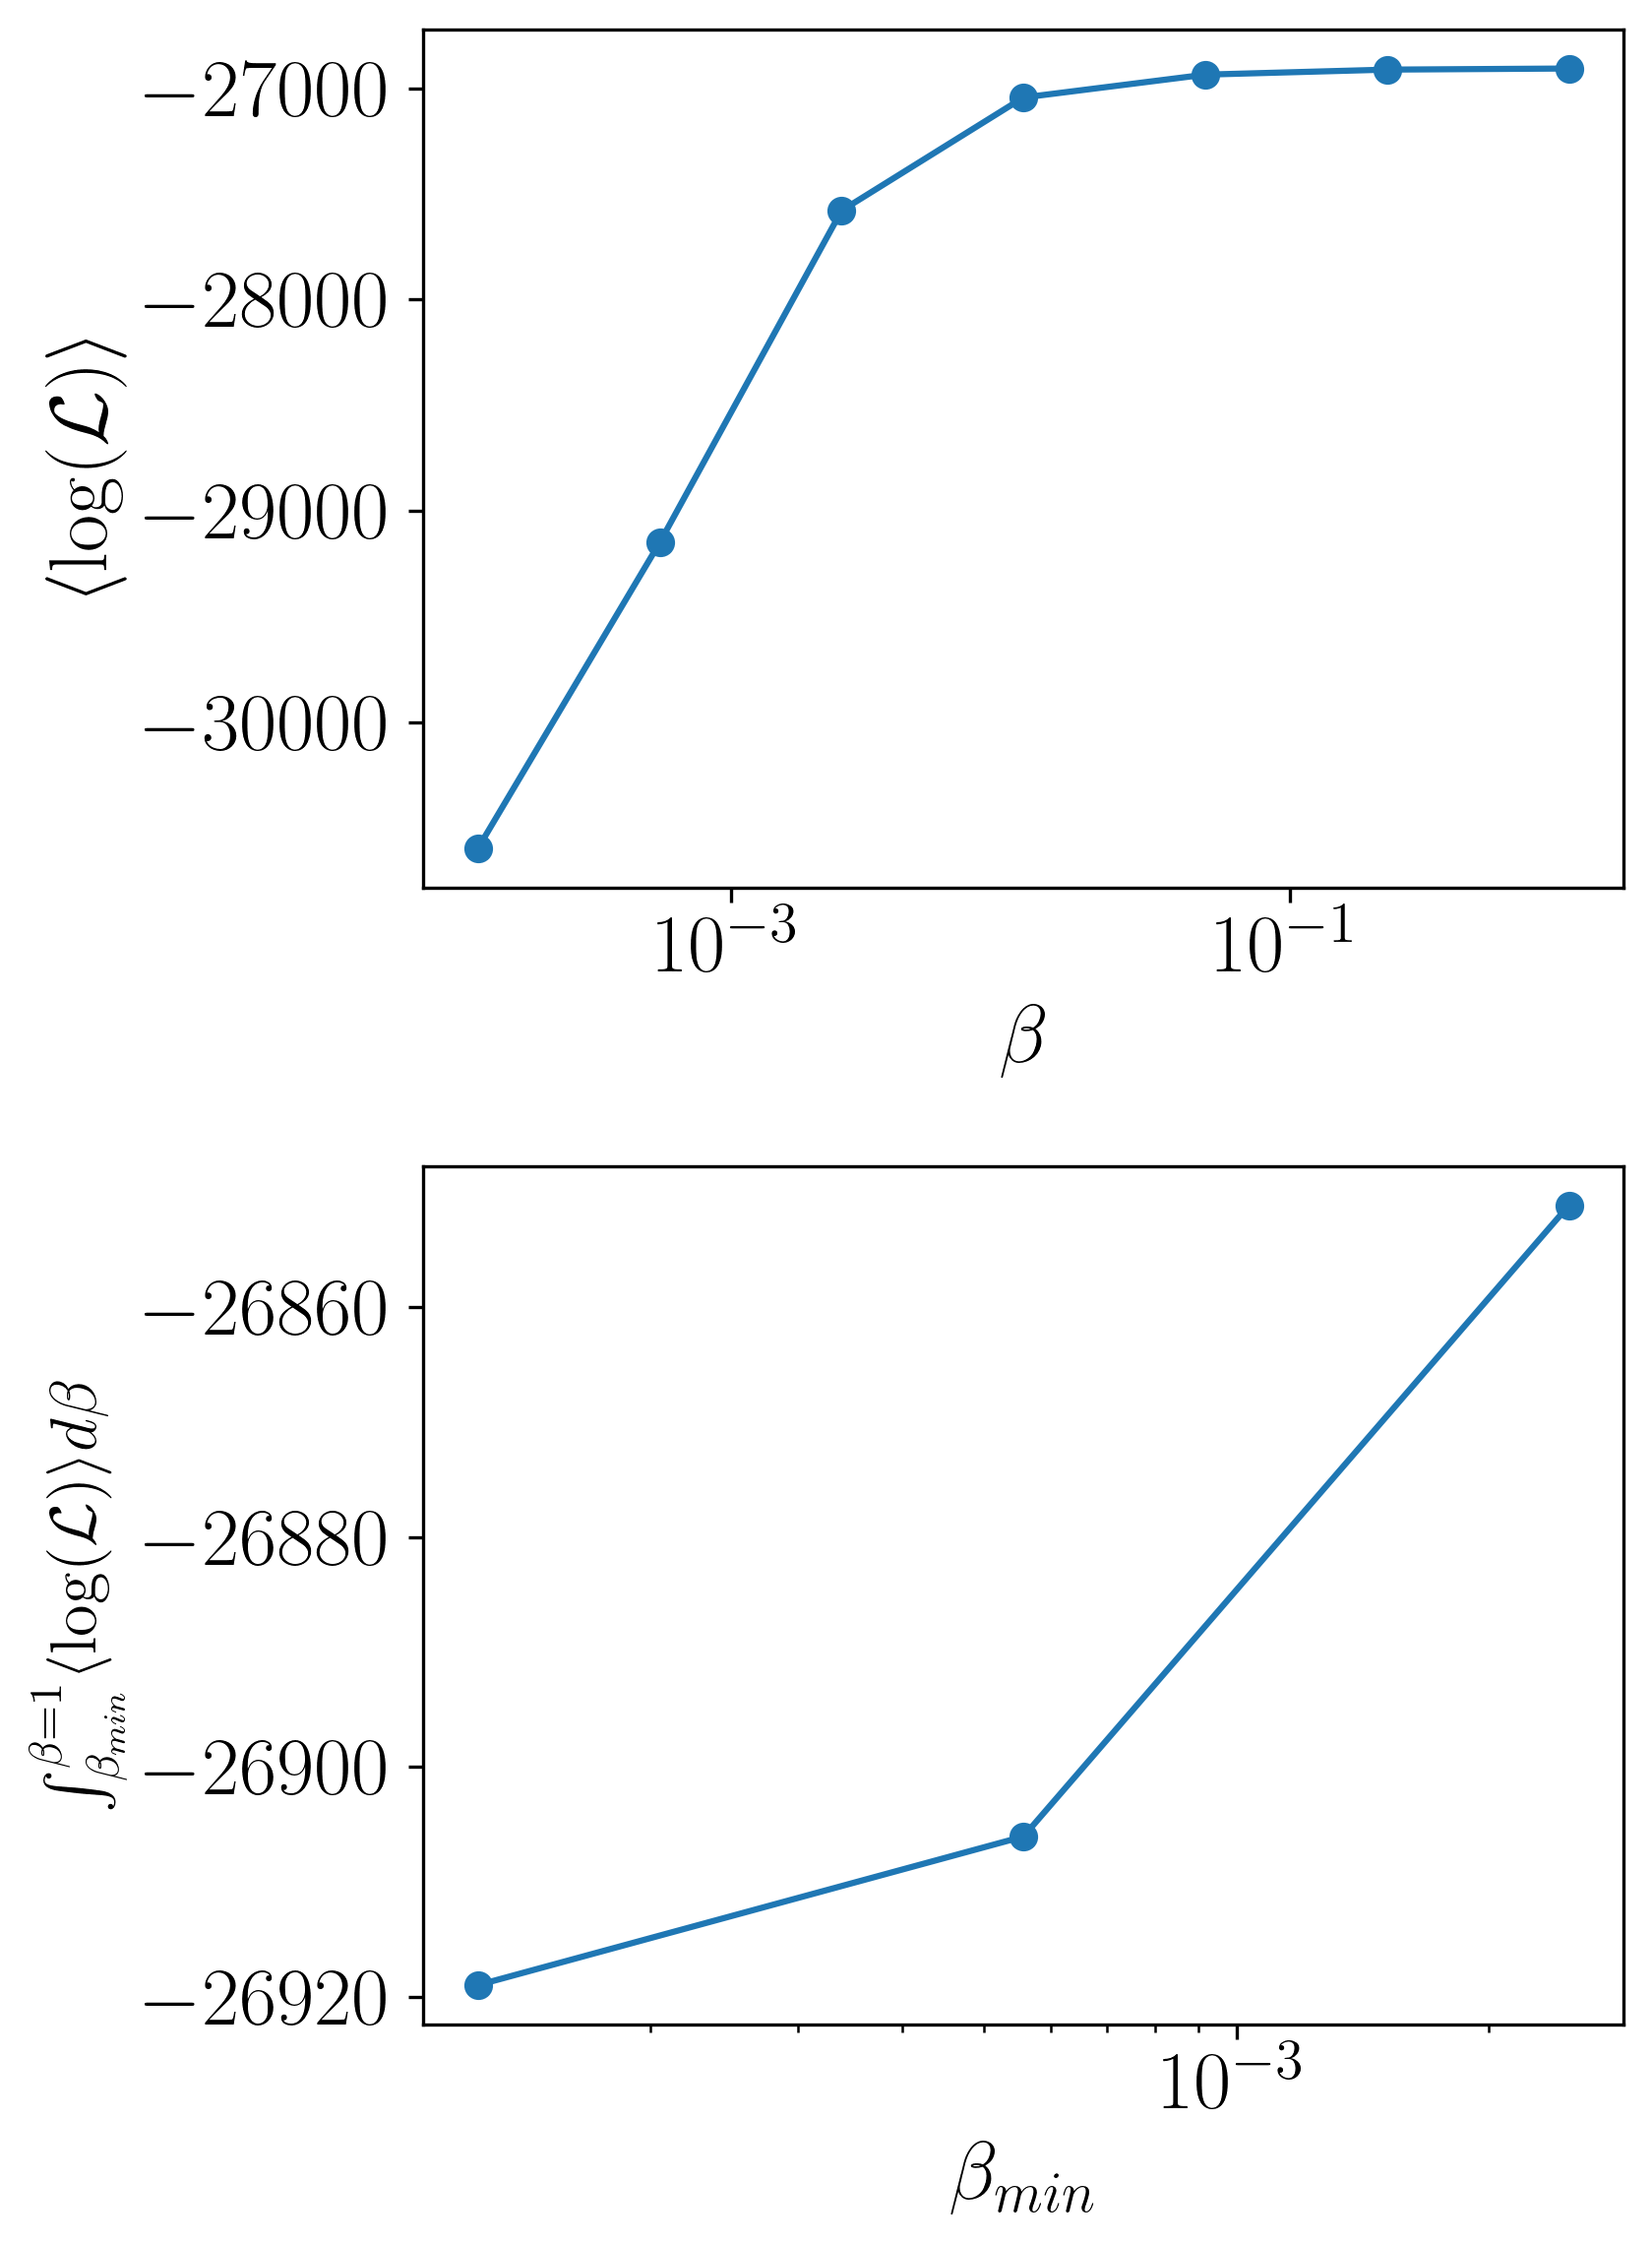

In [9]:
generalized_gaussian_likelihood = GeneralizedNormalLikelihood(data)

priors_pt = dict(
    mu=bilby.core.prior.Uniform(minimum=0,maximum=5, latex_label=r"$\mu$"),
    alpha=bilby.core.prior.Uniform(minimum=0,maximum=10 * np.sqrt(2), latex_label=r"$\alpha$"),
    beta=bilby.core.prior.Uniform(minimum=0,maximum=10, latex_label=r"$\beta$")
)

result_hybrid_pt = bilby.run_sampler(
    likelihood=generalized_gaussian_likelihood, 
    pos0     = pos0, 
    priors   = priors_pt, 
    outdir   = outdir_pt,
    ntemps   = ntemps,
    betas    = beta_T,
    nwalkers = nwalkers,
    label    = label_pt, 
    sampler  = 'ptemcee',
    npool = 4
)

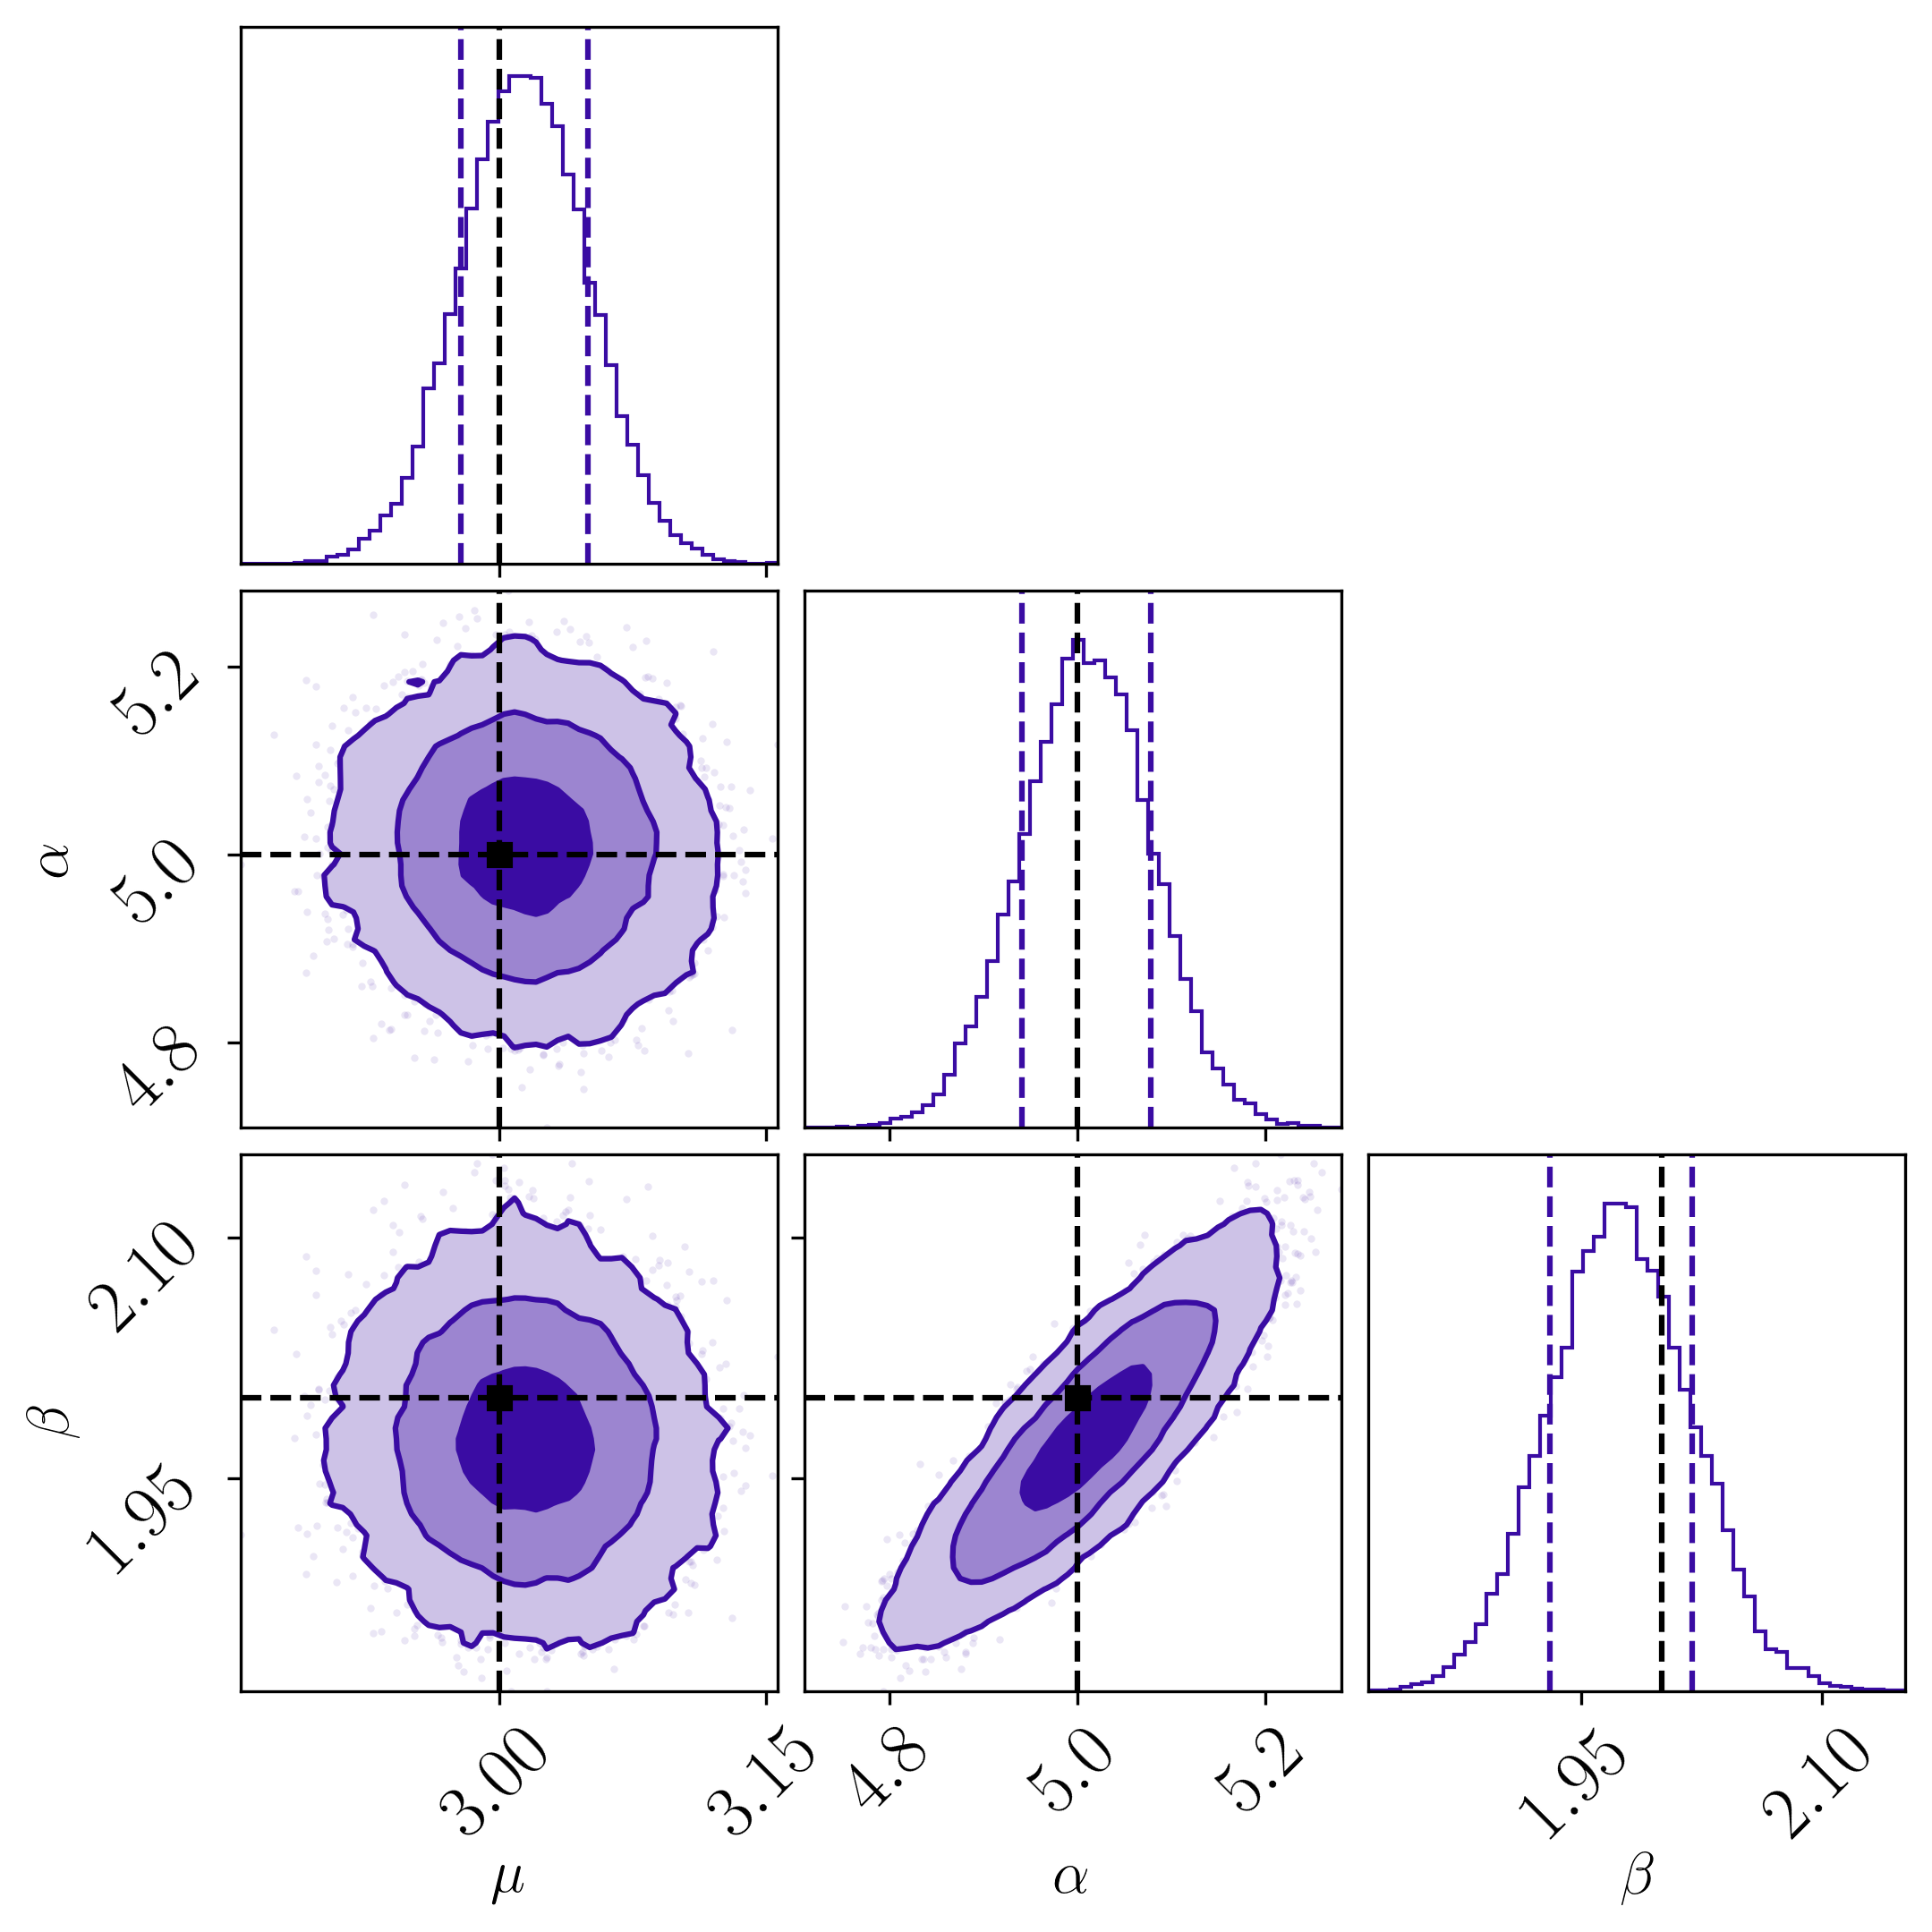

In [10]:
with plt.rc_context({'lines.linestyle' : '--'}):
    fig = result_hybrid_pt.plot_corner(
        parameters=dict(
            mu=mu_true,
            alpha=alpha_true,
            beta=beta_true
        ),
        titles=False,
        color=HYBRID_COLOR,
        truth_color="black"
    )

fig

## With Dynesty Only

In [11]:
label_nest_only = "wellspecified_dynesty-only"
outdir_nest_only = "./wellspecified/wellspecified_dynesty-only" 

generalized_gaussian_likelihood = GeneralizedNormalLikelihood(data)
priors_nest_only = dict(
    mu=bilby.core.prior.Uniform(minimum=0,maximum=5, latex_label=r"$\mu$"),
    alpha=bilby.core.prior.Uniform(minimum=0,maximum=10 * np.sqrt(2), latex_label=r"$\alpha$"),
    beta=bilby.core.prior.Uniform(minimum=0,maximum=10, latex_label=r"$\beta$")
)

nlive = 500

# And run sampler
result_hybrid_nest_only = bilby.run_sampler(
    likelihood=generalized_gaussian_likelihood, priors=priors_nest_only, sampler='dynesty', npoints=nlive,
    walks=10, outdir=outdir_nest_only, label=label_nest_only)

21:29 bilby INFO    : Running for label 'wellspecified_dynesty-only', output will be saved to './wellspecified/wellspecified_dynesty-only'
21:29 bilby INFO    : Search parameters:
21:29 bilby INFO    :   mu = Uniform(minimum=0, maximum=5, name=None, latex_label='$\\mu$', unit=None, boundary=None)
21:29 bilby INFO    :   alpha = Uniform(minimum=0, maximum=14.142135623730951, name=None, latex_label='$\\alpha$', unit=None, boundary=None)
21:29 bilby INFO    :   beta = Uniform(minimum=0, maximum=10, name=None, latex_label='$\\beta$', unit=None, boundary=None)
21:29 bilby INFO    : Single likelihood evaluation took 2.761e-04 s


0it [00:00, ?it/s]

21:29 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fc323722f40>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
21:29 bilby INFO    : Checkpoint every check_point_delta_t = 600s
21:29 bilby INFO    : Using dynesty version 1.0.1
21:29 bilby INFO    : Using the bilby-implemented rwalk samp

8000it [01:45, 65.48it/s, bound:1019 nc: 50 ncall:3.3e+05 eff:2.4% logz=-26918.77+/-1.32 dlogz:0.101>0.1]  

21:31 bilby INFO    : Written checkpoint file ./wellspecified/wellspecified_dynesty-only/wellspecified_dynesty-only_resume.pickle
21:31 bilby INFO    : Writing 1527 current samples to ./wellspecified/wellspecified_dynesty-only/wellspecified_dynesty-only_samples.dat
/Users/newolfe/opt/anaconda3/envs/tgr-hybrid-analysis/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


8006it [01:53, 70.31it/s, bound:1020 nc:  1 ncall:3.3e+05 eff:2.6% logz=-26918.68+/-1.32 dlogz:0.000>0.1]



21:31 bilby INFO    : Sampling time: 0:01:45.756240
21:31 bilby INFO    : Summary of results:
nsamples: 8506
ln_noise_evidence:    nan
ln_evidence: -26918.680 +/-  1.317
ln_bayes_factor:    nan +/-  1.317



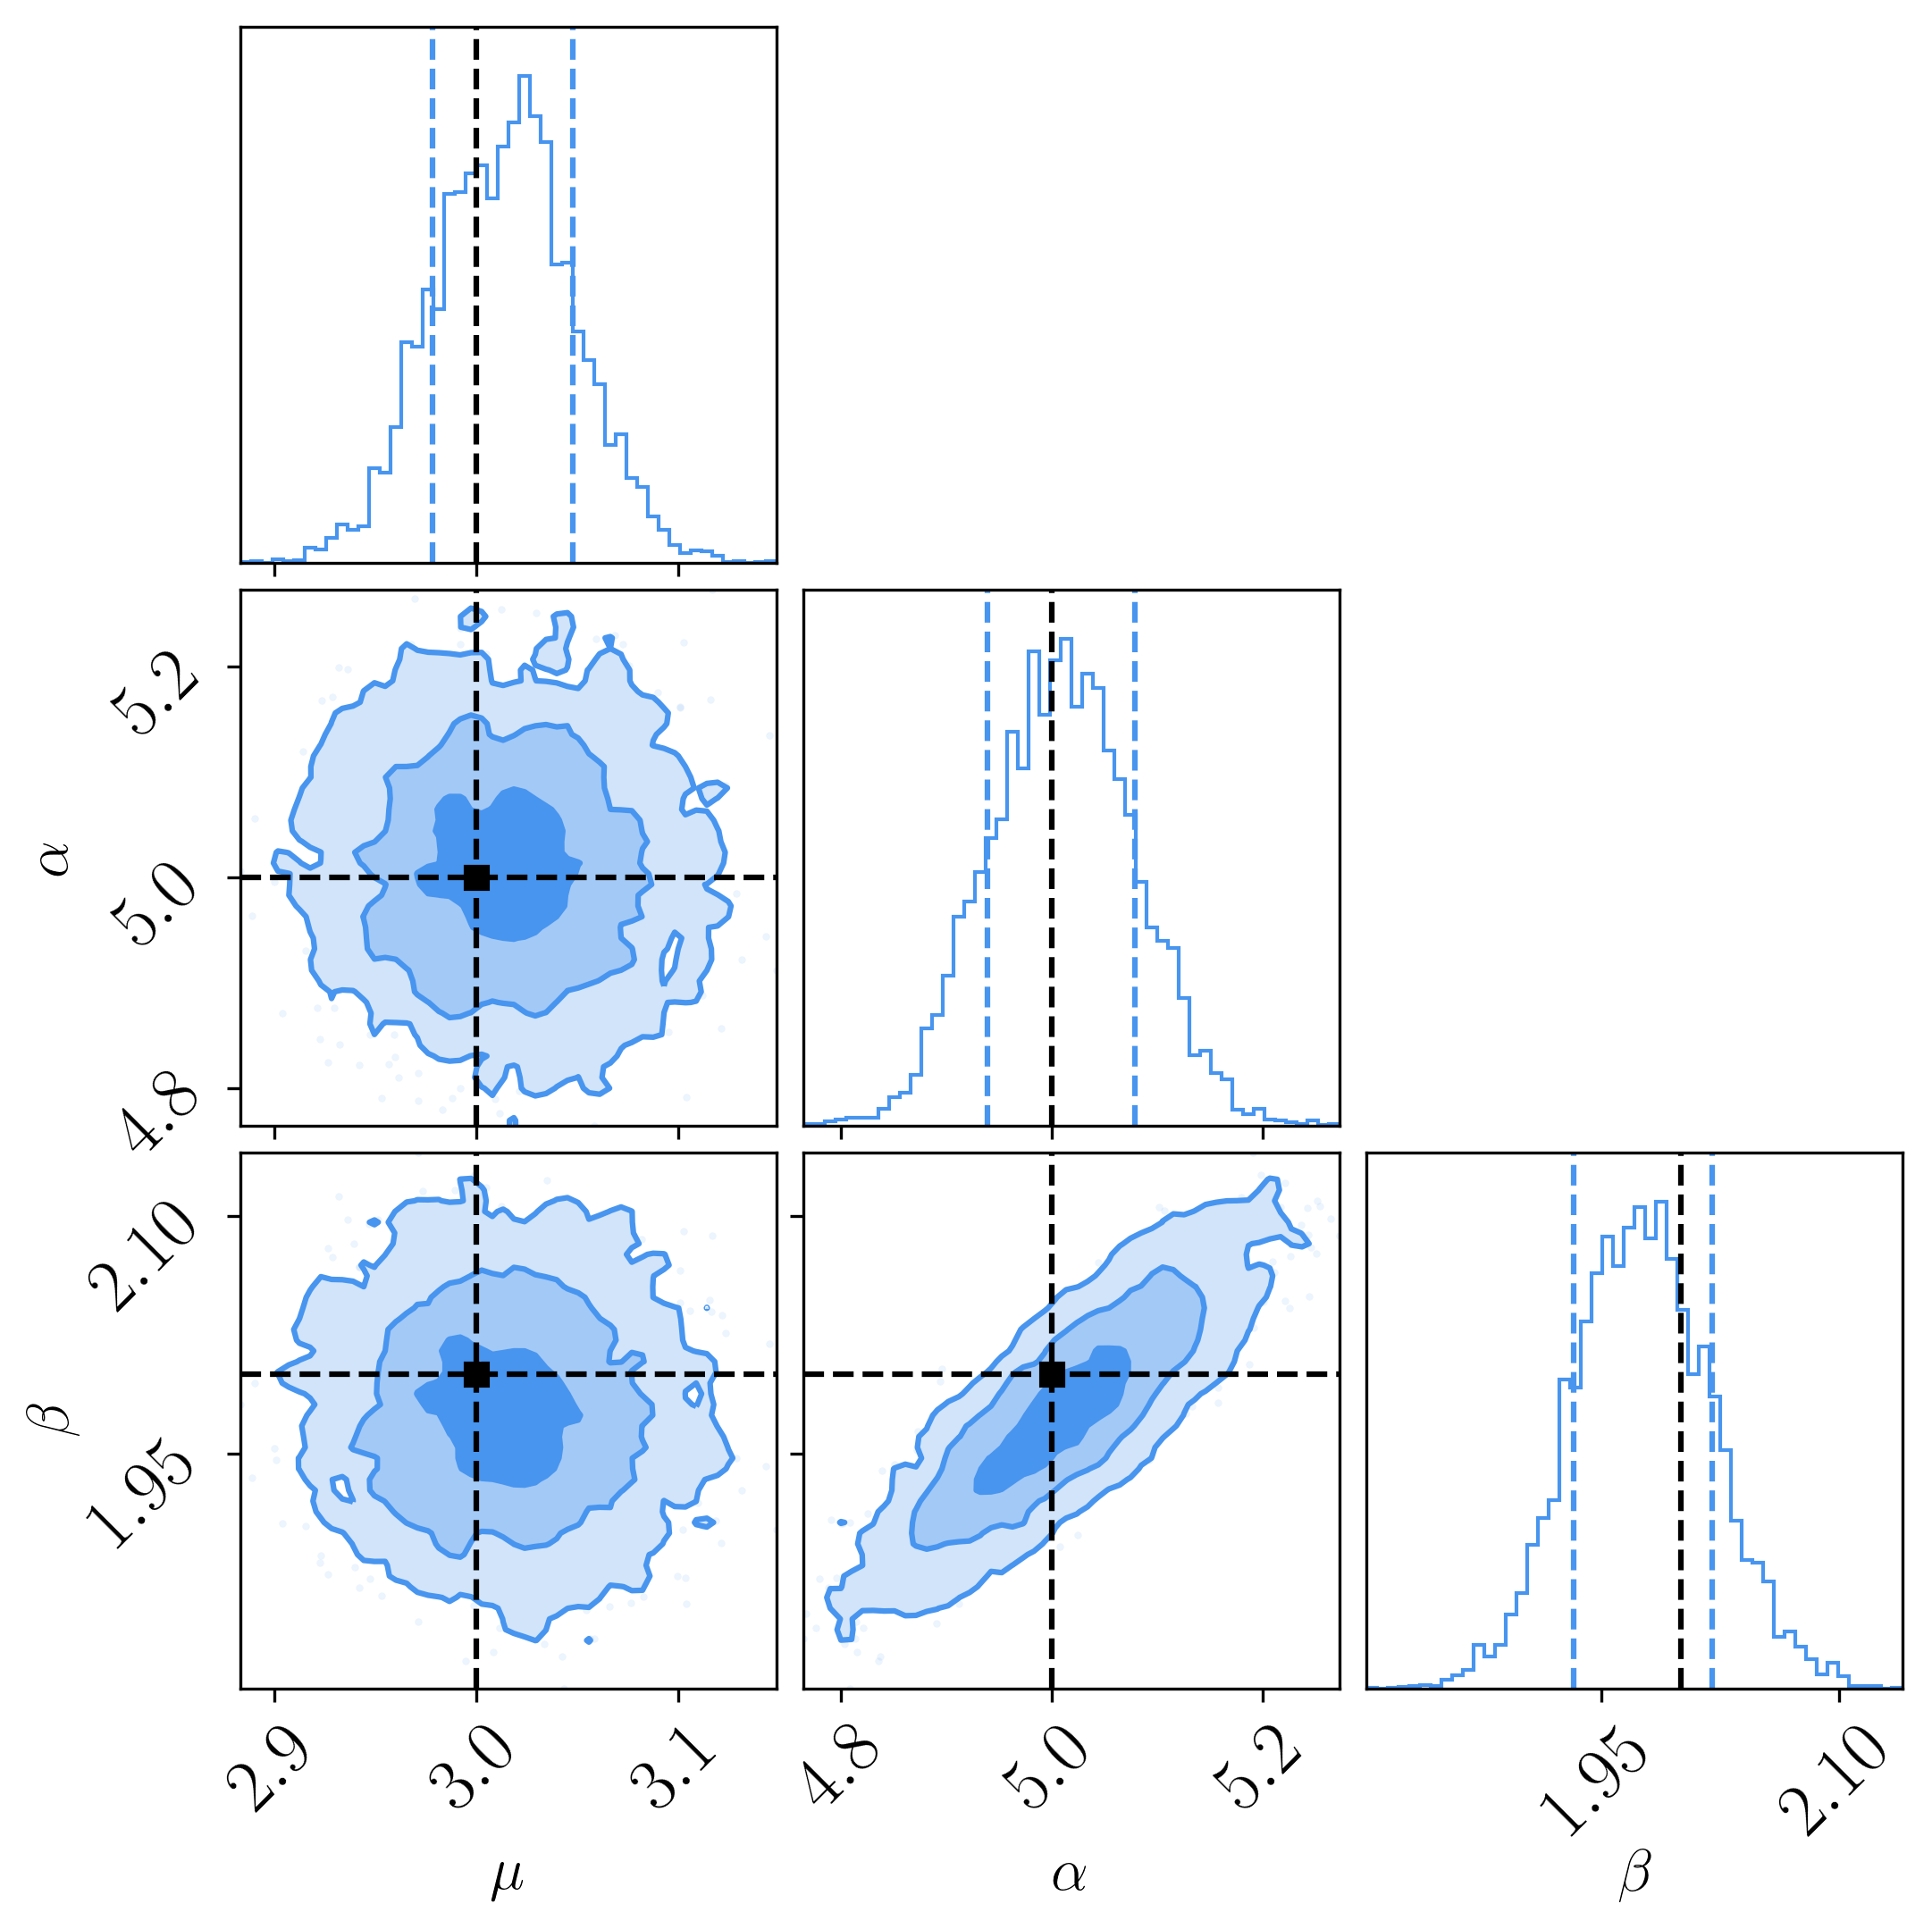

In [12]:
with plt.rc_context({'lines.linestyle' : '--'}):
    fig = result_hybrid_nest_only.plot_corner(
        parameters=dict(
            mu=mu_true,
            alpha=alpha_true,
            beta=beta_true
        ),
        titles=False,
        labels=[r"$\mu$", r"$\alpha$", r"$\beta$"],
        color=COMP_COLOR,
        truth_color="black"
    )

fig

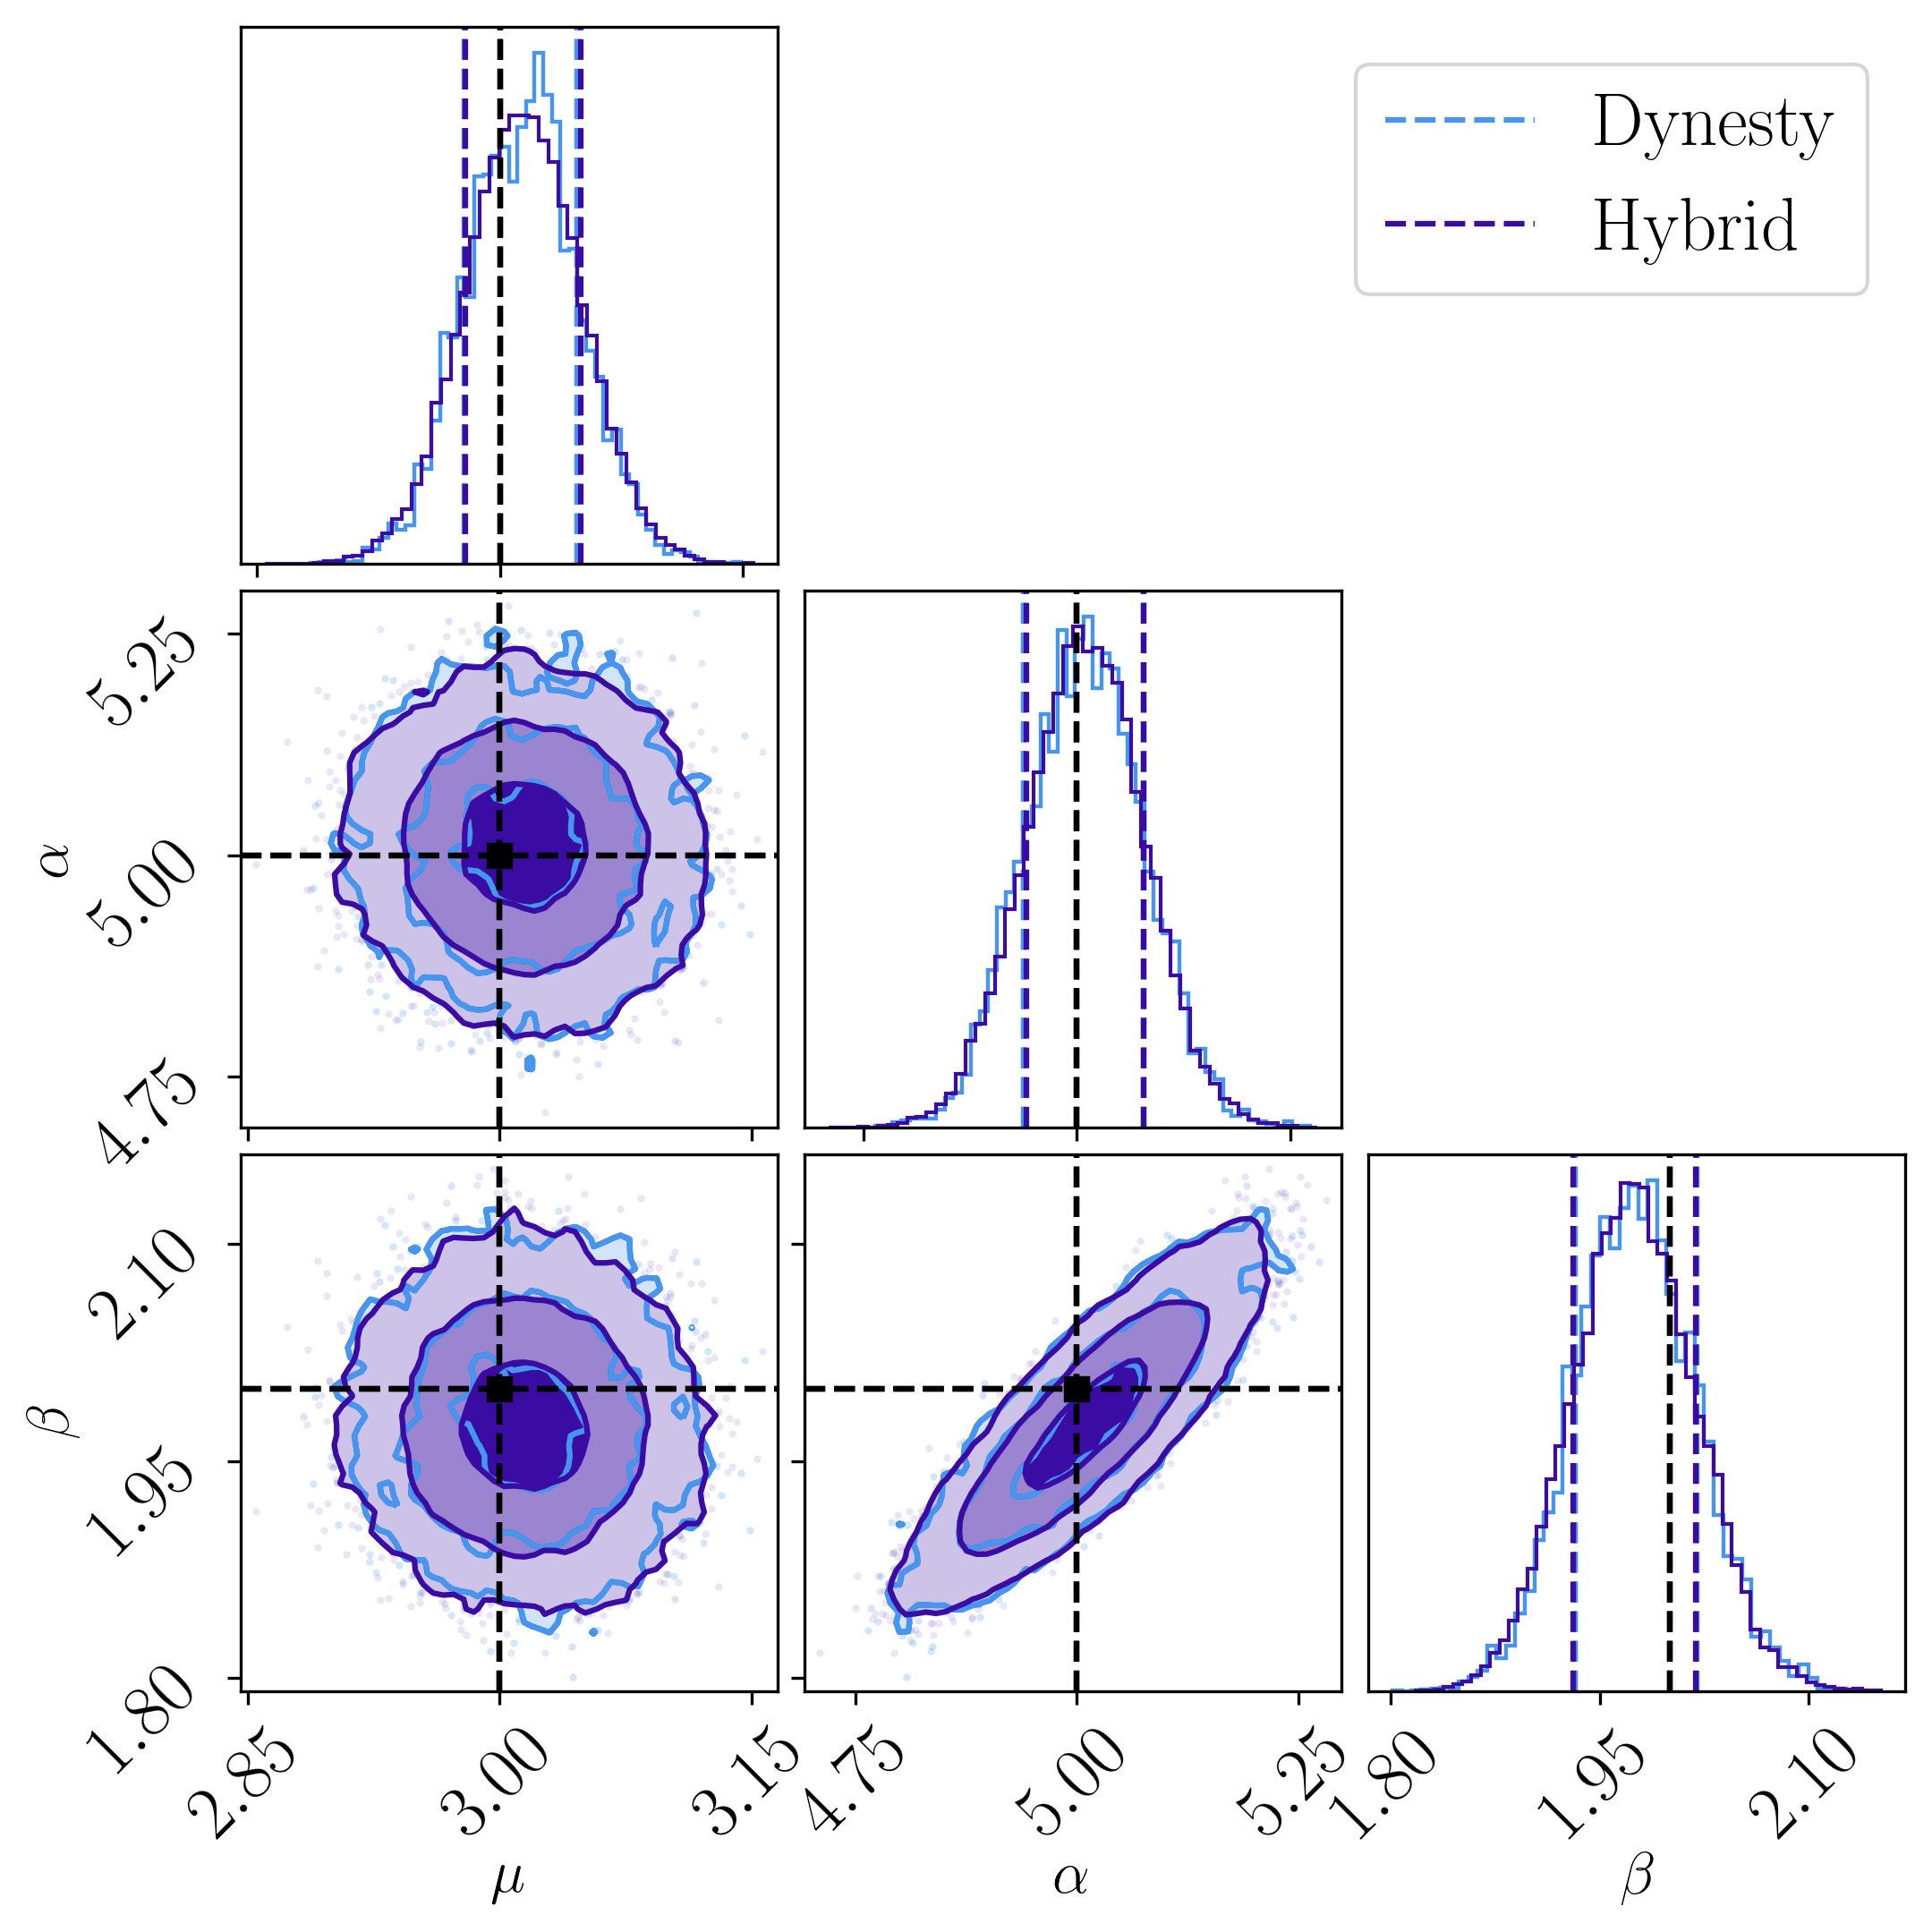

In [13]:
## Combined Corner plot of dynesty-only, hybrid results
with plt.rc_context({'lines.linestyle' : '--'}):
    fig = bilby.core.result.plot_multiple(
        [result_hybrid_nest_only, result_hybrid_pt],
        labels=["Dynesty", "Hybrid"],
        colours=[COMP_COLOR, HYBRID_COLOR],
        titles=False,
        truth_color="black",
        parameters=dict(
            mu=mu_true,
            alpha=alpha_true,
            beta=beta_true
        ),
    )